# Assignment 3 - Segmentation

You are expected to complete this notebook with lines of code, plots and texts. You will need to create new cells with original code or text for your analyses. This assignment has a total of 100 points and 5 questions.

Using Canvas, you will deliver the notebook file (.ipynb) with cells executed and outputs visible.
- You should use PyTorch 1.0 or later as your deep learning framework. If you need to import a different package than the ones already imported, ask the TA if you can do it.
- No other data than the dataset variables provided should be used, and training, validation and testing splits should be the same as the ones provided.
- The cell outputs present in your delivered notebook should be reproducible by us by running your notebook cells in order.
- All code must be your own work. Code cannot be copied from another source or student. You may copy code from cells that were pre-defined in this notebook if you think it is useful for use in another part of the notebook.
- All images must be generated from data generated in your code. Do NOT import/display images generated outside your code.
- Your analysis must be your own, but if you quote text or equations from another source make sure to cite the reference.
- It is assumed that PyTorch is already installed according to the CADE or the COLAB tutorial.
- For all analyses you write, in the case that you ran code to get to its conclusions, you should provide code that provides evidence for these conclusions. This code should print the numbers that are cited, or plot a graph, or print a table, or, even better, a combination of these. Do not erase or comment code and its outputs in the case you cite them in your analyses.
- You should provide evidence that your code satisfies all the constraints of the questions. For showing that numeric constraints are satisfied, provide some kind of printed number, and not only a graph.

Other notes:
- Cells should be run in order, using Shift+Enter.
- Read all the provided code cells and its comments, as it contains variables and information that you may need to use to complete the notebook.
- To create a text cell, create it with the "+" button and change its type from "Code" to "Markdown" using the top menu. To modify a text cell, double click on it.
- If you are interested, you can check detail on formatting markdown text here: https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed
- The accuracies provided as required for each question are there to make sure you work enough on each model to get a good result. Part of the grade is based on this.
- We assume a GPU of at least 4GB of memory is available. If you want to try running the assignment with a GPU that has less than that, you can try changing the argument passed when calling the ```define_gpu_to_use``` function.  If you are getting out-of-memory errors for the GPU, you may want to check what is occupying the GPU memory by using the command ```!nvidia-smi```, which gives a report of the use of the GPU. 
- A few PyTorch details to remember:
    - Remember to toggle train/eval mode for your model
    - Remember to reset the gradients with ```zero_grad()``` before each call to ```backward()```
    - Remember to check if the loss you are using receives logits or probabilities, and adapt your model output accordingly.
    - Remember to reinstantiate your model every time you are starting a new training, so that weights are reset.
    - Remember to pass to the optimizer the set of parameters for the model you want to train.

#### Initial setups

In [1]:
!pip3 install imageio
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

In [2]:
#importing the libraries used in the rest of hte code
import os
import gzip
import shutil
import tarfile
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import collections
from skimage import morphology
from skimage.measure import block_reduce
import scipy
from torch.utils.data import Dataset
import PIL
from PIL import Image
from sklearn.metrics import f1_score
import copy
import random
import math
import torch

In [3]:
#checking what kind of system you are using
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [4]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
if IN_CADE:
    #setting the gpu that will be used, testing if it has enough available memory, and reserving the needed memory
    define_gpu_to_use()

Chosen GPU: 0


#### Defining functions used to load the dataset

We are going to use datasets of retinal digital images and segment the blood vessels from it. We are going to use the DRIVE dataset (https://www.isi.uu.nl/Research/Databases/DRIVE/) and the STARE dataset (http://cecas.clemson.edu/~ahoover/stare/) together in this assignment. We are going to use our own train/validation/test splits, even though the DRIVE dataset provides its own split. Please download the files named "DRIVE.zip" (register in https://www.isi.uu.nl/Research/Databases/DRIVE/download.php and follow the instructions), "stare-images.tar" (http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar), "labels-vk.tar" (http://cecas.clemson.edu/~ahoover/stare/probing/labels-vk.tar) and put in the same folder as this notebook file so that the dataset can be loaded. 

The dataset also contains masks since the images are not shaped as squares originally, but are only padded so that we can fit them to a traditional CNN. The masks contain the information of where the original image is and where the padding is located. These masks should be used to limit where outputs are backpropagated for training and what region of the image should be used for scoring. In the mask, 1 means that it is part of the original image, and 0 means that it in the zero-padded region.

In [6]:
#delete small regions (<size) of binary images
def remove_small_regions(img, size):
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [7]:
#resize the images of the dataset to be half the height and half the width of the original images, so 
# that models states can fit on the GPU memory
def resize_img(img):
    if len(img.shape)==3:
        img = np.array(Image.fromarray(img).resize(((img.shape[1]+1)//2,(img.shape[0]+1)//2), PIL.Image.BILINEAR))
    else:
        img = block_reduce(img, block_size=(2, 2), func=np.max)
    return img

In [8]:
#unzips, loads and calculates masks for images from the stare dataset
def stare_read_images(tar_filename, dest_folder, do_mask = False):
    tar = tarfile.open(tar_filename)
    tar.extractall(dest_folder)
    tar.close()
    all_images = []
    all_masks = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith('gz'):
            with gzip.open(dest_folder + item, 'rb') as f_in:
                with open(dest_folder + item[:-3], 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            os.remove(dest_folder + item) 
            img = imageio.imread(dest_folder + item[:-3])
            if len(img.shape) == 3:
                img = np.pad(img , ((1,2), (2,2),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((1,2), (2,2)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
            if do_mask:
                mask = (1-remove_small_regions(np.prod((img<50/255.)*1.0, axis = 2)>0.5, 1000))*1.0
                mask = np.expand_dims(mask, axis = 2)
                all_masks.append(mask.astype(np.float32))
    if do_mask:
        return all_images, all_masks
    else:
        return all_images

In [9]:
#unzips and loads masks for images from the stare dataset
def drive_read_images(filetype, dest_folder):
    zip_ref = zipfile.ZipFile('DRIVE.zip', 'r')
    zip_ref.extractall('datasets/drive')
    zip_ref.close()
    all_images = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith(filetype):
            img = imageio.imread(dest_folder + item)
            if len(img.shape) == 3:
                img = np.pad(img , ((12,12), (69,70),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((12,12), (69,70)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
    return all_images

In [10]:
#load all images and put them on a list of list of arrays.
# on the inner lists, first element is an input image, second element is a segmentation groundtruth
# and third element is a mask to show where the input image is valid, in contrast to where it was padded
def get_retina_array():
    stare_images, stare_mask = stare_read_images("stare-images.tar", 'datasets/stare/images/', do_mask = True)            
    stare_segmentation = stare_read_images("labels-vk.tar", 'datasets/stare/segmentations/')   
    drive_training_images = drive_read_images('tif', 'datasets/drive/DRIVE/training/images/')
    drive_test_images = drive_read_images('tif', 'datasets/drive/DRIVE/test/images/')
    drive_training_segmentation = drive_read_images('gif', 'datasets/drive/DRIVE/training/1st_manual/')
    drive_test_segmentation = drive_read_images('gif', 'datasets/drive/DRIVE/test/1st_manual/')
    drive_training_mask = drive_read_images('gif', 'datasets/drive/DRIVE/training/mask/')
    drive_test_mask = drive_read_images('gif', 'datasets/drive/DRIVE/test/mask/')
    return list(zip(stare_images+drive_training_images+drive_test_images, 
                           stare_segmentation+drive_training_segmentation+drive_test_segmentation, 
                           stare_mask + drive_training_mask + drive_test_mask))

In [11]:
#split can be 'train', 'val', and 'test'
#this is the function that splits a dataset into training, validation and testing set
#We are using a split of 70%-10%-20%, for train-val-test, respectively
#this function is used internally to the defined dataset classes
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [12]:
#for segmentations tasks, the exact transformations that are applied to 
# the input image should be applied, down to the random number used, should
# also be applied to the ground truth and to the masks. We redefine a few of
# PyTorch classes 

#apply transoforms to all tensors in list x 
def _iterate_transforms(transform, x):
    for i, xi in enumerate(x):
        x[i] = transform(x[i])
    return x

#redefining composed transform so that it uses the _iterate_transforms function
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for transform in self.transforms:
            x = _iterate_transforms(transform, x) 
        return x

#class to rerandomize the vertical flip transformation   
class RandomVerticalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

#class to perform vertical flip using randomization provided by gen
class RandomVerticalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            return torch.flip(img, [2])
        return img

#class to rerandomize the horizontal flip transformation   
class RandomHorizontalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

#class to perform horizontal flip using randomization provided by gen
class RandomHorizontalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            return torch.flip(img, [1])
        return img 

In [13]:
#Dataset class for the retina dataset
# each item of the dataset is a tuple with three items:
# - the first element is the input image to be segmented 
# - the second element is the segmentation ground truth image 
# - the third element is a mask to know what parts of the input image should be used (for training and for scoring)
class RetinaDataset(Dataset):
    def transpose_first_index(self, x):
        x2 = (np.transpose(x[0], [2,0,1]), np.transpose(x[1], [2,0,1]), np.transpose(x[2], [2,0,1]))
        return x2
    
    def __init__(self, retina_array, split = 'train', do_transform=False):
        indexes_this_split = get_split(np.arange(len(retina_array), dtype = np.int), split)
        self.retina_array = [self.transpose_first_index(retina_array[i]) for i in indexes_this_split]
        self.split = split
        self.do_transform = do_transform
    def __getitem__(self, index):
        sample = [torch.FloatTensor(x) for x in self.retina_array[index]]
        if self.do_transform:
            v_gen = RandomVerticalFlipGenerator()
            h_gen = RandomHorizontalFlipGenerator()
            t = Compose([
                v_gen,
                RandomVerticalFlip(gen=v_gen),
                h_gen,
                RandomHorizontalFlip(gen=h_gen),
            ])
            sample = t(sample)
        return sample
    
    def __len__(self):
        return len(self.retina_array)

#### Loading and visualizing the dataset

In [15]:
retina_array = get_retina_array()
#datase to use for training:
train_dataset = RetinaDataset(retina_array, do_transform = True)
#dataset to use for validation
val_dataset = RetinaDataset(retina_array, split = 'val')
#dataset to use for testing
test_dataset = RetinaDataset(retina_array, split = 'test')

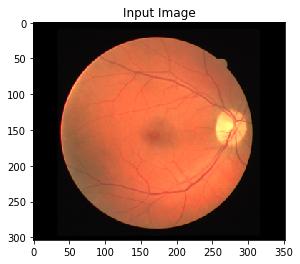

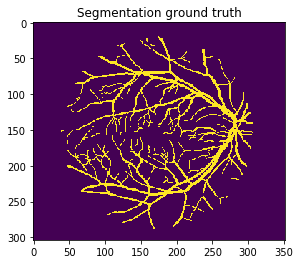

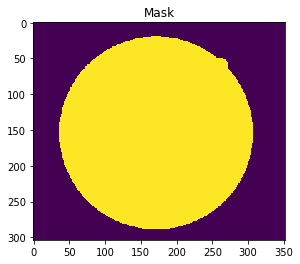

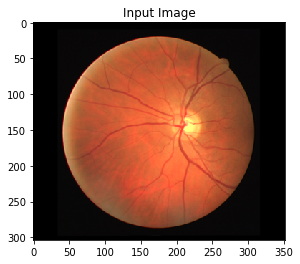

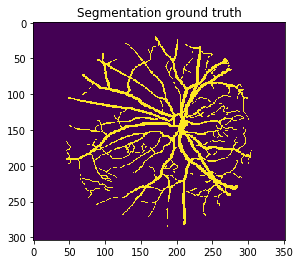

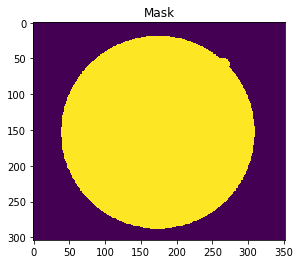

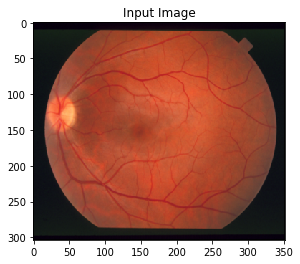

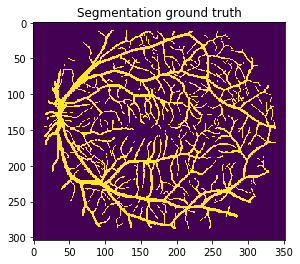

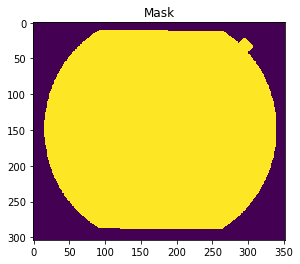

In [16]:
#Visualing a few cases in the training set
for batch_idx, (data, segmentation, mask) in enumerate( RetinaDataset(retina_array)):
    if batch_idx%15 == 0: 
        plt.figure()
        plt.title("Input Image")
        plt.imshow(data[:,:,:].permute([1,2,0]).cpu().numpy())
        plt.figure()
        plt.title("Segmentation ground truth")
        plt.imshow(segmentation[0,:,:].cpu().numpy())
        plt.figure()
        plt.title("Mask")
        plt.imshow(mask[0,:,:].cpu().numpy())
    

#### Defining a scoring function

To measure how good our segmentation results are, we are going to use the F1 score. This score is the harmonic mean between precision and recall, considering the foreground as the positive class and the background as the negative class. The score goes from 0 to 1, with 1 the best score possible. 

In [17]:
#use this function to score your models
def get_score_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1, 304, 352])
        segmentations = np.zeros([0, 1, 304, 352])
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, segmentation, mask  in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy()*mask.numpy()), axis = 0)
            segmentations = np.concatenate((segmentations, segmentation.cpu().detach().numpy()*mask.numpy()), axis = 0)   
    #returns a list of scores, one for each of the labels
    return f1_score(segmentations.reshape([-1]), logits_predicted.reshape([-1])>0)

#### Q1 (13 points)
Justify why data augmentation usually helps in improving scores in deep learning tasks, and why horizontal flipping and vertical flipping make sense for this dataset. Would they both make sense in a natural image dataset? List at least one other kind of data augmentation that could also be applied for the retina blood vessels segmentation, and justify why.

#### answer:
##### why data augmentation usually helps in improving scores in deep learning tasks
Data augmentation can help us increase the size of the dataset. Increase in the number of training data would help increase the accuracy of the network and prevents overfitting. Also it would help generate the data that are not captured during data gathering. For example, if we have a dataset of horses that lacks or has a little amount of the case where the horse is looking to the left. By horizontally flipping the images in this dataset, it will be able to detect that scenario too. Overall, it would make the network more robust to the changes that may occur during the test time. 
##### why does horizontal flipping and vertical flipping make sense for this dataset?
##### List at least one other kind of data augmentation that could also be applied for the retina blood vessels segmentation, and justify why.

Because the data is taken from a sphere and its 2D image is a circle, flipping it horizontally and vertically would not change the vital information of the image. Ideally, the network should robust to any rotation in the dataset. Therefore, we should be able to do the data augmentation by rotating the image and also scaling. These can make it robust to the imaging apparatus (devices from different companies may give the different domain of the eye) and also any human error like tilting the head a little or not putting the camera at the exact distance from the eye. 
#####  Would they both make sense in a natural image dataset?
Based on the dataset either one of the flipping would make sense. For example, if it is a dataset of the landscapes, vertical flipping would not make sense, but horizontal flipping would help the learning process. If it is a dataset of flowers, vertical flipping would make sense too. <br>
Generally, augmentation should add data that would be possible in the real world. Otherwise, it would add complications to the training that is not necessary.



#### Q2 (11 points)
Check how balanced the dataset is, showing how many negative labels there are for each positive label. Use this information to change the weighting of the positive class in the loss for Question 3 and Question 5, and explain why in some cases using the weighting helps in improving performance.

In [20]:
ones = 0
for data, segmentation, mask in RetinaDataset(retina_array):
    ones += np.sum(segmentation.cpu().numpy()==1)/np.prod(segmentation.cpu().numpy().shape)
ones /= len(RetinaDataset(retina_array))
print('percentage of positive pixels in the whole data set:', ones*100, '%')
pos_weight = (float(((1-ones)/ones))*torch.ones(segmentation.shape)).cuda()

percentage of positive pixels in the whole data set: 10.9640445218159 %


This shows that only 10.96% of the data is positive while the other 89.04% is negative. The positive values are the pixels of interest, so putting more weight on them would help us get better results. In some sense, not getting the positive pixels correct would have more penalty than having a positive pixel in a part that should be negative. <br>
The weight has opposite corelation with the population and would be 89.04/10.96 for positive values in the data.

#### Q3 (45 points)
Build a u-net model class that inherits from the torch.nn.Module class. Follow the model as described in the original paper (https://arxiv.org/pdf/1505.04597.pdf - Fig. 1 and Section 2), but with these modifications chosen to simplify the assignment and to reduce memory use:
- Add 2D batch normalizations between convolutions and ReLUs.
- Add paddings to the convolutions so that the outputs of the convolutions have the same spatial size as the inputs. Because of this, the cropping before the concatenation of the skip connections is not necessary.
- The upsampling convolutions should be coded using the layer torch.nn.ConvTransposed2D. More details to understand what they meant in the paper can be found in the video here, starting at 2:22:  https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
- Reduce the number of channels of all internal layers dividing them by 8. 
- Input should still have 3 channels, but output should have only one channel (binary output). 
- You can use PyTorch's weight initialization. You do not need to implement the initialization of weights as described in the u-net paper.

Use the masks provided with the dataset to mask your loss. Your loss should only backpropagate through the pixels where the mask has a value of 1, and not backpropagate where the mask is 0. Hyperparameters and methods to use are provided in the code cell below. Use the learning rate scheduler for training too. Your network should be able to get an F1 score of at least 0.75 in the validation set of the provided dataset, using the ``get_score_model`` function. Test your model on the test set.


In [18]:
class UNet(torch.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.convolution_layer_1 = torch.nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding=1)
        self.batch_norm_1 = torch.nn.BatchNorm2d(num_features=8)
        self.relu = torch.nn.ReLU()
        self.maxpooling_layer = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.convolution_layer_2 = torch.nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, padding=1)
        self.batch_norm_2 = torch.nn.BatchNorm2d(num_features=8)
        self.convolution_layer_3 = torch.nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding=1)
        self.batch_norm_3 = torch.nn.BatchNorm2d(num_features=16)
        self.convolution_layer_4 = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding=1)
        self.batch_norm_4 = torch.nn.BatchNorm2d(num_features=16)
        self.convolution_layer_5 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding=1)
        self.batch_norm_5 = torch.nn.BatchNorm2d(num_features=32)
        self.convolution_layer_6 = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1)
        self.batch_norm_6 = torch.nn.BatchNorm2d(num_features=32)
        self.convolution_layer_7 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding=1)
        self.batch_norm_7 = torch.nn.BatchNorm2d(num_features=64)
        self.convolution_layer_8 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding=1)
        self.batch_norm_8 = torch.nn.BatchNorm2d(num_features=64)
        self.convolution_layer_9 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding=1)
        self.batch_norm_9 = torch.nn.BatchNorm2d(num_features=128)
        self.convolution_layer_10 = torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding=1)
        self.batch_norm_10 = torch.nn.BatchNorm2d(num_features=128)
        
        #upsampling
        self.uppooling_layer_1 = torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        self.convolution_layer_11 = torch.nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding=1)
        self.batch_norm_11 = torch.nn.BatchNorm2d(num_features=64)
        self.convolution_layer_12 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding=1)
        self.batch_norm_12 = torch.nn.BatchNorm2d(num_features=64)
        self.uppooling_layer_2 = torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32, kernel_size = 2, stride = 2)
        self.convolution_layer_13 = torch.nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1)
        self.batch_norm_13 = torch.nn.BatchNorm2d(num_features=32)
        self.convolution_layer_14 = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1)
        self.batch_norm_14 = torch.nn.BatchNorm2d(num_features=32)
        self.uppooling_layer_3 = torch.nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 2, stride = 2)
        self.convolution_layer_15 = torch.nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding=1)
        self.batch_norm_15 = torch.nn.BatchNorm2d(num_features=16)
        self.convolution_layer_16 = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding=1)
        self.batch_norm_16 = torch.nn.BatchNorm2d(num_features=16)
        self.uppooling_layer_4 = torch.nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size = 2, stride = 2)
        self.convolution_layer_17 = torch.nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, padding=1)
        self.batch_norm_17 = torch.nn.BatchNorm2d(num_features=8)
        self.convolution_layer_18 = torch.nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, padding=1)
        self.batch_norm_18 = torch.nn.BatchNorm2d(num_features=8)
        
        #output
        self.convolution_layer_out = torch.nn.Conv2d(in_channels = 8, out_channels = 1, kernel_size = 1)
        
    def forward(self, x):
        x = self.convolution_layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        x = self.convolution_layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x1 = x
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.convolution_layer_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)
        x2 = x
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_5(x)
        x = self.batch_norm_5(x)
        x = self.relu(x)
        x = self.convolution_layer_6(x)
        x = self.batch_norm_6(x)
        x = self.relu(x)
        x3 = x
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_7(x)
        x = self.batch_norm_7(x)
        x = self.relu(x)
        x = self.convolution_layer_8(x)
        x = self.batch_norm_8(x)
        x = self.relu(x)
        x4 = x
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_9(x)
        x = self.batch_norm_9(x)
        x = self.relu(x)
        x = self.convolution_layer_10(x)
        x = self.batch_norm_10(x)
        x = self.relu(x)
        
        
        # upsampling part
        x = self.uppooling_layer_1(x)
        x = torch.cat((x4,x),dim=1)
        x = self.convolution_layer_11(x)
        x = self.batch_norm_11(x)
        x = self.relu(x)
        x = self.convolution_layer_12(x)
        x = self.batch_norm_12(x)
        x = self.relu(x)
        x = self.uppooling_layer_2(x)
        x = torch.cat((x3,x),dim=1)
        x = self.convolution_layer_13(x)
        x = self.batch_norm_13(x)
        x = self.relu(x)
        x = self.convolution_layer_14(x)
        x = self.batch_norm_14(x)
        x = self.relu(x)
        x = self.uppooling_layer_3(x)
        x = torch.cat((x2,x),dim=1)
        x = self.convolution_layer_15(x)
        x = self.batch_norm_15(x)
        x = self.relu(x)
        x = self.convolution_layer_16(x)
        x = self.batch_norm_16(x)
        x = self.relu(x)
        x = self.uppooling_layer_4(x)
        x = torch.cat((x1,x),dim=1)
        x = self.convolution_layer_17(x)
        x = self.batch_norm_17(x)
        x = self.relu(x)
        x = self.convolution_layer_18(x)
        x = self.batch_norm_18(x)
        x = self.relu(x)
        
        #output
        x = self.convolution_layer_out(x)
        return x

We are comparing the probability for each pixel to be 1. So, the loss function of choice should be 'BCEWithLogitsLoss'. This is more numerically stable than adding a sigmoid layer to the network and 'BCEloss' as the loss function.
Also, we are adding weight to the loss function for positive values as described above. It is same for any position.

In [21]:
criterion = torch.nn.BCEWithLogitsLoss(weight= pos_weight)

In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = UNet()
model = model.cuda()

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
# Learning rate is reduced after plateauing to stabilize the end of training.
# use the learning rate scheduler as defined here. Example on how to integrate it to training in
# https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

#train your model here:
for epoch in range(n_epochs):
    
    # taking steps in scheduler
    scheduler.step()
    
    losses=[]
    
    # toggling to training mode
    model.train()
    
    
    for image, segmentation, mask in train_loader:
        
        # zero grading the optimizer
        optimizer.zero_grad()
        
        # transfering data to cuda unit
        image= image.cuda()
        segmentation= segmentation.cuda()
        mask= mask.cuda()
        
        # finding output of the model and using mask on it
        out = model(image)
        out = out.mul(mask)
        
        # back propagation
        loss = criterion(out, segmentation)
        
        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.item()) # 6) 7)
        
    print('Epoch ' + str(epoch)) # 6)
    print('loss1: ' + str(np.mean(losses))) # 6)

        

Epoch 0
loss1: 5.388306277138846
Epoch 1
loss1: 4.6843768528529575
Epoch 2
loss1: 4.646207196371896
Epoch 3
loss1: 4.629321915762765
Epoch 4
loss1: 4.589275087629046
Epoch 5
loss1: 4.579192978995187
Epoch 6
loss1: 4.571391786847796
Epoch 7
loss1: 4.557236875806536
Epoch 8
loss1: 4.5408638545445035
Epoch 9
loss1: 4.484863417489188
Epoch 10
loss1: 4.373245988573347
Epoch 11
loss1: 4.249625137874058
Epoch 12
loss1: 4.122424227850778
Epoch 13
loss1: 4.016779286520822
Epoch 14
loss1: 3.917285544531686
Epoch 15
loss1: 3.853640147617885
Epoch 16
loss1: 3.7825590882982527
Epoch 17
loss1: 3.736126661300659
Epoch 18
loss1: 3.701057127543858
Epoch 19
loss1: 4.093222754342215
Epoch 20
loss1: 4.020446504865374
Epoch 21
loss1: 3.8264615876334056
Epoch 22
loss1: 3.7667843954903737
Epoch 23
loss1: 3.6978627613612582
Epoch 24
loss1: 3.656228951045445
Epoch 25
loss1: 3.640549898147583
Epoch 26
loss1: 3.6175056866237094
Epoch 27
loss1: 3.5871944086892262
Epoch 28
loss1: 3.5649629661015103
Epoch 29
loss1:

#### Calculating F-1 score for validation and test set

In [23]:
print('The F-1 score for the validation set:', get_score_model(model, val_loader))

The F-1 score for the validation set: 0.7902286127919154


In [24]:
print('The F-1 score for the validation set:', get_score_model(model, test_loader))

The F-1 score for the validation set: 0.7765421258456695


#### Q4 (8 points)
Visualize a few outputs of your network in the validation set and compare with your ground truth. Comment on the kinds of mistakes that you are able to distinguish.

In the images below, input images are raw data input to the model. Ground truth is the provided labeling of the data showing where the blood vessels are. Model outputs are the output of the model which we get from the last layer of the network. Model label is the label for each pixel based on the output of the model. To get the label, we apply a sigmoid function on the model output and assign value of 1 for any pixel with value greater than 0.5.

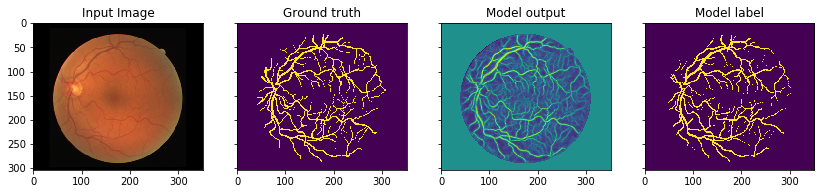

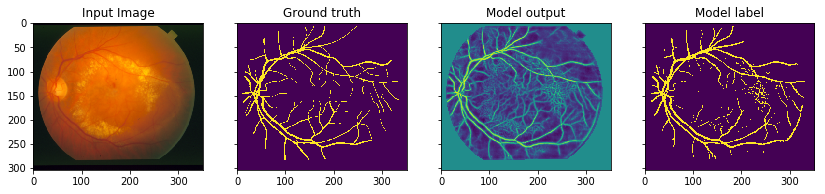

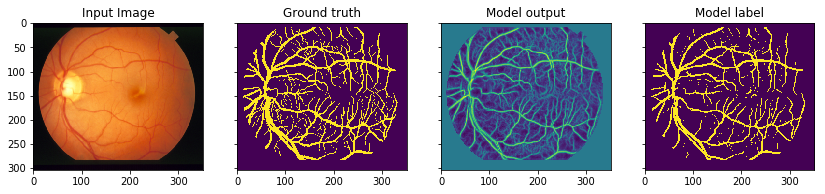

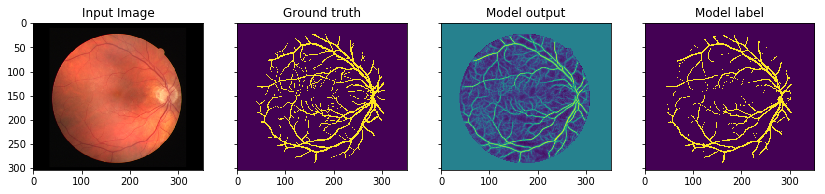

In [26]:
i=0 
for data, segmentation, mask in val_loader:
    i+=1
    if i<5:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True,figsize=(14,14))
        model.eval()
        mask= mask.cuda()
        out= model(data.cuda()).mul(mask)
        ax1.set_title("Input Image")
        ax1.imshow(data[0,:,:,:].permute([1,2,0]).cpu().numpy())
        ax2.set_title("Ground truth")
        ax2.imshow(segmentation[0,0,:,:].cpu().numpy())
        ax3.set_title("Model output")
        ax3.imshow(out[0,0,:,:].cpu().detach().numpy())
        ax4.set_title("Model label")
        ax4.imshow((torch.sigmoid(out)>0.5)[0,0,:,:].cpu().detach().numpy()>0.5)
    else:
        break

It can be seen form the visualized data that the model performs pretty well on the data, but it has not catched some thin blood vessels. It has done pretty good job finding the main blood vessels though. Although at some parts in the main blood vessels, the thickness is less than the ground thruth. The accuaracy never would be 100% but the factors that are impacting the prediction seems to be loss of information in downsampling and also the fact that the ground truth labeling may not be perfect and may include some human error.

#### Q5 (23 points)
Modify your u-net module to receive a boolean argument in initialization/contruction that can deactivate the use of the skip connections. To compensate for not having the extra channels coming from the skip connection, you should double the number of channels out of the upsampling layer when skip connections are deactivated. Train and test the network without the skip connections, using the hyperparameters as provided in the cell below. You should be able to get an F1 score of at least 0.5.  When compared to the network trained on Question 3, which network performs better? Explain why that happens, detailing the role of the skip connections for a segmentation task. Link your explanations to visualizations of the output of the network without skip connections.

In the network below, skip is the boolean argument that can deactivate the use of skip connections. If skip is True, the network would be similar to the one in Q3. If skip is Not True, the network would deactivate the use of skip connections.

In [27]:
class UNetwithskip(torch.nn.Module):
    
    def __init__(self, skip = True):
        self.skip=skip
        
        if skip is True:
            dum1= 1
        else:
            dum1= 2
        
        super(UNetwithskip, self).__init__()
        self.convolution_layer_1 = torch.nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 3, padding=1)
        self.batch_norm_1 = torch.nn.BatchNorm2d(num_features=8)
        self.relu = torch.nn.ReLU()
        self.maxpooling_layer = torch.nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.convolution_layer_2 = torch.nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, padding=1)
        self.batch_norm_2 = torch.nn.BatchNorm2d(num_features=8)
        self.convolution_layer_3 = torch.nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding=1)
        self.batch_norm_3 = torch.nn.BatchNorm2d(num_features=16)
        self.convolution_layer_4 = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding=1)
        self.batch_norm_4 = torch.nn.BatchNorm2d(num_features=16)
        self.convolution_layer_5 = torch.nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 3, padding=1)
        self.batch_norm_5 = torch.nn.BatchNorm2d(num_features=32)
        self.convolution_layer_6 = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1)
        self.batch_norm_6 = torch.nn.BatchNorm2d(num_features=32)
        self.convolution_layer_7 = torch.nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, padding=1)
        self.batch_norm_7 = torch.nn.BatchNorm2d(num_features=64)
        self.convolution_layer_8 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding=1)
        self.batch_norm_8 = torch.nn.BatchNorm2d(num_features=64)
        self.convolution_layer_9 = torch.nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, padding=1)
        self.batch_norm_9 = torch.nn.BatchNorm2d(num_features=128)
        self.convolution_layer_10 = torch.nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = 3, padding=1)
        self.batch_norm_10 = torch.nn.BatchNorm2d(num_features=128)
        
        #upsampling
        self.uppooling_layer_1 = torch.nn.ConvTranspose2d(in_channels = 128, out_channels = 64*dum1, kernel_size = 2, stride = 2)
        self.convolution_layer_11 = torch.nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3, padding=1)
        self.batch_norm_11 = torch.nn.BatchNorm2d(num_features=64)
        self.convolution_layer_12 = torch.nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, padding=1)
        self.batch_norm_12 = torch.nn.BatchNorm2d(num_features=64)
        self.uppooling_layer_2 = torch.nn.ConvTranspose2d(in_channels = 64, out_channels = 32*dum1, kernel_size = 2, stride = 2)
        self.convolution_layer_13 = torch.nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, padding=1)
        self.batch_norm_13 = torch.nn.BatchNorm2d(num_features=32)
        self.convolution_layer_14 = torch.nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, padding=1)
        self.batch_norm_14 = torch.nn.BatchNorm2d(num_features=32)
        self.uppooling_layer_3 = torch.nn.ConvTranspose2d(in_channels = 32, out_channels = 16*dum1, kernel_size = 2, stride = 2)
        self.convolution_layer_15 = torch.nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = 3, padding=1)
        self.batch_norm_15 = torch.nn.BatchNorm2d(num_features=16)
        self.convolution_layer_16 = torch.nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size = 3, padding=1)
        self.batch_norm_16 = torch.nn.BatchNorm2d(num_features=16)
        self.uppooling_layer_4 = torch.nn.ConvTranspose2d(in_channels = 16, out_channels = 8*dum1, kernel_size = 2, stride = 2)
        self.convolution_layer_17 = torch.nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 3, padding=1)
        self.batch_norm_17 = torch.nn.BatchNorm2d(num_features=8)
        self.convolution_layer_18 = torch.nn.Conv2d(in_channels = 8, out_channels = 8, kernel_size = 3, padding=1)
        self.batch_norm_18 = torch.nn.BatchNorm2d(num_features=8)
        
        #output
        self.convolution_layer_out = torch.nn.Conv2d(in_channels = 8, out_channels = 1, kernel_size = 1)
        
    def forward(self, x):
        x = self.convolution_layer_1(x)
        x = self.batch_norm_1(x)
        x = self.relu(x)
        x = self.convolution_layer_2(x)
        x = self.batch_norm_2(x)
        x = self.relu(x)
        x1 = x
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_3(x)
        x = self.batch_norm_3(x)
        x = self.relu(x)
        x = self.convolution_layer_4(x)
        x = self.batch_norm_4(x)
        x = self.relu(x)
        x2 = x
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_5(x)
        x = self.batch_norm_5(x)
        x = self.relu(x)
        x = self.convolution_layer_6(x)
        x = self.batch_norm_6(x)
        x = self.relu(x)
        x3 = x
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_7(x)
        x = self.batch_norm_7(x)
        x = self.relu(x)
        x = self.convolution_layer_8(x)
        x = self.batch_norm_8(x)
        x = self.relu(x)
        x4 = x
        x = self.maxpooling_layer(x)
        x = self.convolution_layer_9(x)
        x = self.batch_norm_9(x)
        x = self.relu(x)
        x = self.convolution_layer_10(x)
        x = self.batch_norm_10(x)
        x = self.relu(x)
        
        
        # upsampling part
        x = self.uppooling_layer_1(x)
        if self.skip is True:
            x = torch.cat((x4,x),dim=1)
        x = self.convolution_layer_11(x)
        x = self.batch_norm_11(x)
        x = self.relu(x)
        x = self.convolution_layer_12(x)
        x = self.batch_norm_12(x)
        x = self.relu(x)
        x = self.uppooling_layer_2(x)
        if self.skip is True:
            x = torch.cat((x3,x),dim=1)
        x = self.convolution_layer_13(x)
        x = self.batch_norm_13(x)
        x = self.relu(x)
        x = self.convolution_layer_14(x)
        x = self.batch_norm_14(x)
        x = self.relu(x)
        x = self.uppooling_layer_3(x)
        if self.skip is True:
            x = torch.cat((x2,x),dim=1)
        x = self.convolution_layer_15(x)
        x = self.batch_norm_15(x)
        x = self.relu(x)
        x = self.convolution_layer_16(x)
        x = self.batch_norm_16(x)
        x = self.relu(x)
        x = self.uppooling_layer_4(x)
        if self.skip is True: 
            x = torch.cat((x1,x),dim=1)
        x = self.convolution_layer_17(x)
        x = self.batch_norm_17(x)
        x = self.relu(x)
        x = self.convolution_layer_18(x)
        x = self.batch_norm_18(x)
        x = self.relu(x)
        
        #output
        x = self.convolution_layer_out(x)
        return x

In [28]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

#instantiate your model here:
model = UNetwithskip(skip= False)
model = model.cuda()

#torch.nn.init.xavier_uniform_(model.convolution_layer_1.weight);

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
n_epochs = 200
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

#train your model here:
for epoch in range(n_epochs):
    
    scheduler.step()
    
    losses=[]
    
    model.train()
    
    for image, segmentation, mask in train_loader:
        
        optimizer.zero_grad()
        
        image= image.cuda()
        segmentation= segmentation.cuda()
        mask= mask.cuda()
        
        out = model(image)
        out = out.mul(mask)
        
        loss = criterion(out, segmentation)
        
        loss.backward()
        
        optimizer.step()
        
        losses.append(loss.item()) # 6) 7)
        
    print('Epoch ' + str(epoch)) # 6)
    print('loss1: ' + str(np.mean(losses))) # 6)

Epoch 0
loss1: 5.535718645368304
Epoch 1
loss1: 4.809873853410993
Epoch 2
loss1: 4.605212824685233
Epoch 3
loss1: 4.590211732046945
Epoch 4
loss1: 4.578349658421108
Epoch 5
loss1: 4.563538755689349
Epoch 6
loss1: 4.5462605612618585
Epoch 7
loss1: 4.538528306143625
Epoch 8
loss1: 4.517927237919399
Epoch 9
loss1: 4.501016753060477
Epoch 10
loss1: 4.484252316611154
Epoch 11
loss1: 4.456849030085972
Epoch 12
loss1: 4.438988753727505
Epoch 13
loss1: 4.426048415047782
Epoch 14
loss1: 4.4154525484357565
Epoch 15
loss1: 4.391317367553711
Epoch 16
loss1: 4.367546626499721
Epoch 17
loss1: 4.358194078717913
Epoch 18
loss1: 4.32820817402431
Epoch 19
loss1: 4.313124179840088
Epoch 20
loss1: 4.3085159574236185
Epoch 21
loss1: 4.304586478642055
Epoch 22
loss1: 4.282090936388288
Epoch 23
loss1: 4.26235260282244
Epoch 24
loss1: 4.268497398921421
Epoch 25
loss1: 4.231065545763288
Epoch 26
loss1: 4.230273996080671
Epoch 27
loss1: 4.213457448141916
Epoch 28
loss1: 4.203512055533273
Epoch 29
loss1: 4.20339

#### Calculating F-1 score for validation and test set

In [30]:
print('Validation set F1 score is:')
get_score_model(model, val_loader)

Validation set F1 score is:


0.5891225849681718

In [31]:
print('Test set F1 score is:')
get_score_model(model, test_loader)

Test set F1 score is:


0.5720722019281852

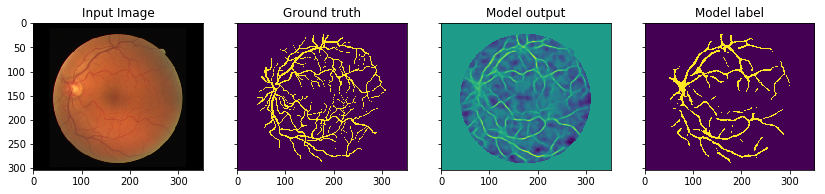

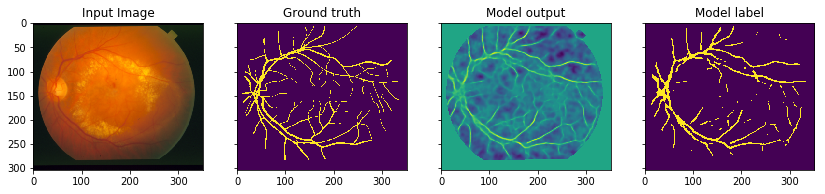

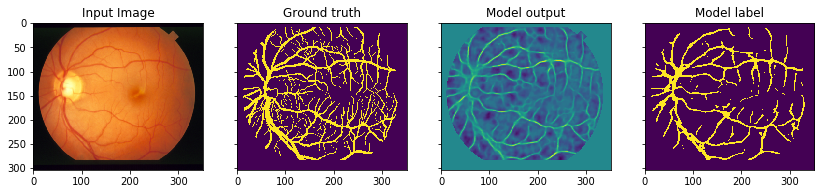

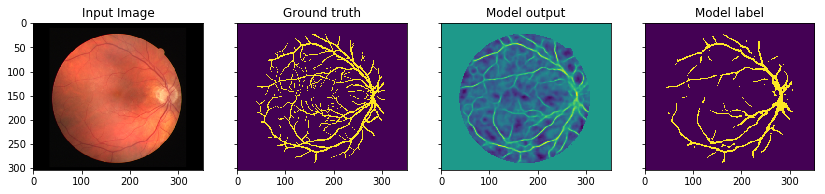

In [33]:
i=0 
for data, segmentation, mask in val_loader:
    i+=1
    if i<5:
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True,figsize=(14,14))
        model.eval()
        mask= mask.cuda()
        out= model(data.cuda()).mul(mask)
        ax1.set_title("Input Image")
        ax1.imshow(data[0,:,:,:].permute([1,2,0]).cpu().numpy())
        ax2.set_title("Ground truth")
        ax2.imshow(segmentation[0,0,:,:].cpu().numpy())
        ax3.set_title("Model output")
        ax3.imshow(out[0,0,:,:].cpu().detach().numpy())
        ax4.set_title("Model label")
        ax4.imshow((torch.sigmoid(out)>0.5)[0,0,:,:].cpu().detach().numpy()>0.5)
    else:
        break

Comparing this with the previous model, both F-1 score and visualization show that the performance of the model with skip connections is better. Based on the visualizations, we can see that the second model has captured less vessels that the previous one. It has almost not detected any thin blood vessels. <br>
This is mainly because of the fact that a lot of positional data are lost in downsampling. At each downsampling layer, in some sense, we are saving one positional data for each 4 positional data. When we concatanate the data from the other side of the network, we add those to the upsampling part. But, when we deactivate the skip layers, network should learn all positional data through upsampling layers this would reduce the accuracy of the network.